# Exercise 6: Pytorch and Feed-Forward Net

In this exercise, you will use pytorch to implement and train a feed-forward net (FFN) for binary sentence classification. The model takes averaged pretrained word embeddings as sentence representations, and classifies them as stemming from author A or B.

This is a very naive model, which cannot represent things like word order or multi-word expressions. However, it is a useful baseline for more complex models. If a complex model, such as a CNN, fails to beat this simple baseline, then there may be something wrong with it.

You should complete the parts of the exercies that are marked as **TODO**.
A correctly completed **TODO** gives 2 bonus points. Partially correct answers give 1 bonus point.
Some **TODO**s are inside a comment in a code block: Here, you should complete the line of code.
Other **TODO**s are inside text blocks: Here, you should write a few sentences to answer the question, preferably inside the same text block.

**Submission deadline:** 07.12.2021

**Instructions for submission:** After completing the exercise, save a copy of the notebook as exercise6_pytorch_MATRIKELNUMMER.ipynb, where MATRIKELNUMMER is your student ID number. Then upload the notebook to moodle (submission exercise sheet 6).

In order to understand the code, it can be helpful to experiment a bit during development. You are welcome to print variables, reduce dataset sizes, or change the hyperparameters. But please remove these changes before submitting the notebook. If we cannot run your notebook (e.g., because you commented out an important variable, or because a print statement is congesting stdout), then we cannot grade it. 

To make the most of this exercise, you should try to read and understand the entire code, not just the parts that contain a **TODO**. If you have questions, write them down for the exercise, which will happen in the week after the submission deadline.

**CUDA:** You can try switching to the GPU for this exercise (on colab: GPU Runtime -> Change Runtime Type). This is not mandatory. Due to the small size of the model, you may not see a major speed-up relative to training on the CPU.

# FastText
We will need pretrained FastText embeddings. Here, we download pretrained embeddings from Facebook AI. If this command doesn't work on your machine, you should download and unzip the file manually and move it to the working directory.

In [ ]:
!if [ -f crawl-300d-2M.vec.zip ]; then rm crawl-300d-2M.vec.zip; fi; 
!if [ -f crawl-300d-2M.vec ]; then rm crawl-300d-2M.vec; fi; 
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
!unzip crawl-300d-2M.vec.zip
!rm crawl-300d-2M.vec.zip
!head -5 crawl-300d-2M.vec

--2021-12-04 19:33:45--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  31.6MB/s    in 46s     

2021-12-04 19:34:32 (31.3 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]

Archive:  crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       
1999995 300
, -0.0282 -0.0557 -0.0451 -0.0434 0.0712 -0.0855 -0.1085 -0.0561 -0.4523 -0.0202 0.0975 0.1047 0.1962 -0.0693 0.0213 -0.0235 0.1336 -0.0420 -0.0564 -0.0798 0.0424 -0.0409 -0.0536 -0.0252 0.0135 0.0064 0.1235 0.0461 0.0120 -0.0372 0.0650 0.0041 -0.1074 -0.0263 0.1133 -0.0029 0.0671 0.1065 0.0234 -0.0160 0.0070 0.435

# Required libraries

In [ ]:
!pip install -q numpy==1.18.0
!pip install -q torch==1.7.0
!pip install -q gensim==3.8.3
!pip install -q matplotlib==3.2.2
!pip install -q nltk==3.2.5
!pip install -q ipywidgets==7.5.1
!pip install -q tqdm==4.41.1

     |████████████████████████████████| 20.1 MB 1.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.6 requires numpy>=1.18.5, but you have numpy 1.18.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 776.7 MB 4.3 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.7.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.7.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1

In [32]:
import torch
import numpy as np
import nltk
import matplotlib.pyplot as pyplot

import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import collections
from tqdm.notebook import tqdm
from gensim.models import KeyedVectors

# Hyperparameters

In [33]:
HIDDEN_SIZE = 30
BATCH_SIZE = 512
MAX_EMBEDDINGS = 400000
PATIENCE = 15

# Data

Here, we load the FastText embeddings into memory. The limit parameter defines how many embeddings (lines) we read.


In [34]:
fasttext = KeyedVectors.load_word2vec_format('crawl-300d-2M.vec',
                                             limit=MAX_EMBEDDINGS)


We will classify sentences as being written by author A (Shakespeare) or author B (Jane Austen).
Targets (classes) are 0 for Shakespeare and 1 for Austen.
For each author, there are two training books and one development book.

In [35]:
BOOKS = {'train': {0.0: ['shakespeare-macbeth.txt', 'shakespeare-caesar.txt'], 
                   1.0: ['austen-sense.txt', 'austen-emma.txt']},
         'dev': {0.0: ['shakespeare-hamlet.txt'], 
                 1.0: ['austen-persuasion.txt']}}

Let's create datasets.
We represent sentences as the mean of their word embeddings.

In [36]:
nltk.download('gutenberg')
nltk.download('punkt')

datasets = {}
for dsetname in ('train', 'dev'):
  inputs, targets = [], []
  for target in (0.0, 1.0):
    for sent in nltk.corpus.gutenberg.sents(BOOKS[dsetname][target]):
      sent = [word for word in sent if word in fasttext]
      if len(sent) > 0: # if all words are unknown, skip sentence
        embedded = np.mean([fasttext[word] for word in sent], 0)
        inputs.append(embedded)
        targets.append(np.array([target]))
  
  inputs = torch.tensor(inputs, dtype=torch.float32)
  
  targets = torch.tensor(targets, dtype=torch.float32)
  dataset = data.TensorDataset(inputs, targets) # TODO: Create a TensorDataset from inputs and targets
  datasets[dsetname] = dataset
  print(targets)

[nltk_data] Downloading package gutenberg to
[nltk_data]     /home/min20120907/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/min20120907/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])
tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])


Let's look at a few datapoints:

In [37]:
for i, (inputs, target) in zip(range(5), datasets['train']):
  print(inputs[:8])
  print(target)

tensor([-0.0822,  0.0306, -0.2864,  0.0185,  0.0347,  0.1339,  0.1732, -0.1981])
tensor([0.])
tensor([-0.1327,  0.0476, -0.3165,  0.1483, -0.2254,  0.0178,  0.2899, -0.0626])
tensor([0.])
tensor([-0.2161, -0.1676, -0.0987,  0.2132, -0.0021,  0.1987,  0.0909,  0.1210])
tensor([0.])
tensor([-0.1247, -0.1852,  0.2241,  0.1931, -0.0819,  0.0157,  0.0958, -0.0313])
tensor([0.])
tensor([-0.1599, -0.0355, -0.0110, -0.0190,  0.1337, -0.1702,  0.2293, -0.0459])
tensor([0.])


# Training loop

Here, we define the training loop.
There are three functions:


*   do_step(...), which performs a single forward pass (and backward pass if necessary) for one batch (one inputs and targets tensor)
*   do_epoch(...), which iterates over a dataloader once
*   training_with_early_stopping(...), which iterates over the epochs

First, you should complete the do_step(...) function:



In [93]:
def do_step(model, inputs, targets, optimizer=None):
  """
  Does a single forward pass (and backward pass if necessary) for one data batch

  @param model nn.Module object
  @param inputs batch tensor (N, input_size)
  @param targets batch tensor (N, 1)
  @param optimizer optimizer object; if None, no backpropagation is done
  """
  loss_function = torch.nn.MSELoss()# TODO: Choose an appropriate loss function for this task.
  
  device = next(model.parameters()).device 
  # this is a hacky way of finding out the device of the model
  # not reliable when different parts of the model live on different devices
  inputs, targets = inputs.to(device=device), targets.to(device=device)

  probabilities = loss_function(inputs, targets)  # TODO: Calculate the predicted probabilities
  loss = loss_function(probabilities, targets) # TODO: Calculate the loss

  if optimizer is not None:
     optimizer.zero_grad()# TODO: Take all necessary steps for gradient backpropagation and parameter updates
     optimizer.step()

  predictions = probabilities / probabilities.max()/1.0  # TODO: Convert probabilities into predictions (0.0 or 1.0) that we can compare against the targets. Assume that the threshold is at 0.5.
  num_correct = (predictions == targets).to(dtype=torch.int32).sum()
  return loss * inputs.shape[0], num_correct

In [94]:
def do_epoch(model, dataloader, optimizer=None):
  """
  Does a single epoch over the dataloader.

  @param model nn.Module object
  @param dataloader dataloader to iterate over
  @param optimizer optimizer object; if None, no backpropagation is done
  """
  all_accuracies = []
  avg_loss, avg_acc = 0.0, 0.0
  for inputs, targets in dataloader:
    loss, acc = do_step(model, inputs, targets, optimizer)
    avg_loss += loss / len(dataloader.dataset)
    avg_acc += acc / len(dataloader.dataset)
  return avg_loss, avg_acc

In this function, you should instantiate the optimizer.
Go to the torch.optim [documentation](https://pytorch.org/docs/stable/optim.html) and pick one of the optimizer classes whose names start with *Ada*.
Don't worry about selecting the "right" optimizer, your guess is as good as anybody else's at this point.

Also, you should set the criterion for early stopping.

In [97]:
def training_with_early_stopping(model, datasets, batch_size=16, patience=0):
  """
  Outer training loop with early stopping.

  @param model nn.Module object
  @param datasets dictionary that contains train and dev datasets
  @param batch_size batch size for training and eval
  @param patience parameter for early stopping on dev_acc
  """

  if torch.cuda.is_available():
    print('Moving model to GPU. Old device:', next(model.parameters()).device)
    model = model.to('cuda')
    print('New device:', next(model.parameters()).device)

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)# TODO: Instantiate your optimizer

  dataloaders = {dsetname: data.DataLoader(datasets[dsetname],
                                           batch_size=batch_size,
                                           shuffle=dsetname=='train') \
                 for dsetname in datasets}

  results = {'train_loss': [], 'train_acc': [], 'dev_loss': [], 'dev_acc': []}

  with tqdm() as progressbar:
    for epoch in range(2000): # stop after 2000 epochs at the latest
      for dsetname, dataloader in dataloaders.items():
        opt = optimizer if dsetname == 'train' else None
        loss, acc = do_epoch(model,
                             dataloader, 
                             optimizer=optimizer if dsetname=='train' else None)
        
        results[f'{dsetname}_loss'].append(loss.to('cpu').detach().numpy())
        results[f'{dsetname}_acc'].append(acc.to('cpu').detach().numpy())

      best_epoch = np.argmax(results['dev_acc'])
      best_dev_acc = results['dev_acc'][best_epoch]
      progressbar.update(1)
      progressbar.set_description(
          f'Best dev acc so far: {best_dev_acc:.5} in epoch {best_epoch}')

      if best_epoch > patience: # TODO: Exit the loop if our highest dev_acc was more than P epochs ago, where P is the patience parameter
        break
  
  return results

Here, you should instantiate two classifier models:
a logistic regression model and a two-layer Feed-Forward Net (FFN).
Each model maps from $N$-dimensional vectors to $1$-dimensional vectors, where $N$ is the vector size of the FastText embeddings.

The logistic regression model consists of a linear layer, followed by a sigmoid activation.

The FFN consists of a linear layer, followed by a relu nonlinearity, followed by a second linear layer, follwed by a sigmoid activation.
The hidden size is stored in the HIDDEN_SIZE hyperparameter.

You can create the models by defining module classes and then instantiating them, as described in the lecture. But there is an easier way ([hint](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)).

In [98]:
torch.manual_seed(0)
if torch.cuda.is_available():
  torch.cuda.manual_seed(0)
# same as the above code
print(inputs.size(dim=0))
print(target.size(dim=0))
logistic = nn.Sequential(collections.OrderedDict([
          ('linear1', nn.Linear(inputs.size(dim=0),target.size(dim=0))),
          ('sigmoid1', nn.Sigmoid())
        ])) # TODO: Logistic regression model (linear -> sigmoid)
ffn = nn.Sequential(collections.OrderedDict([
          ('conv1', nn.Linear(inputs.size(dim=0),target.size(dim=0))),
          ('relu1', nn.ReLU()),
          ('linear1', nn.Linear(inputs.size(dim=0), target.size(dim=0))),
          ('sigmoid1', nn.Sigmoid())
        ])) # TODO: Feed-Forward net (linear -> relu -> linear -> sigmoid)

results = {}
results['logistic'] = training_with_early_stopping(logistic, 
                                                   datasets,
                                                   batch_size=BATCH_SIZE,
                                                   patience=PATIENCE)
results['ffn'] = training_with_early_stopping(ffn, 
                                              datasets,
                                              batch_size=BATCH_SIZE,
                                              patience=PATIENCE)

300
1


# Results

Here, we plot the training loss/accuracy and dev loss/accuracy over the epochs.

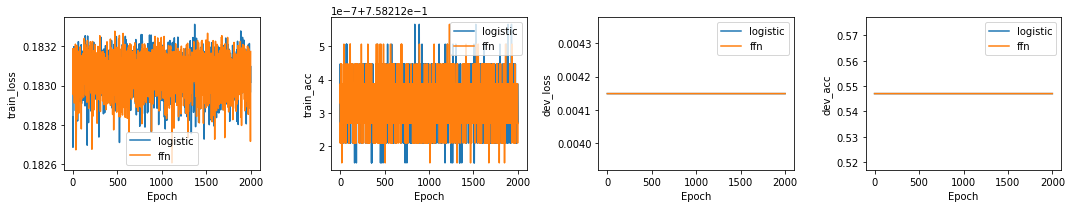

In [99]:
fig, plots = pyplot.subplots(ncols=4, figsize=(15,3))
for modelname, result in results.items():
  for key, plot in zip(result.keys(), plots.flatten()):
    plot.plot(result[key], label=modelname)
    plot.set_xlabel('Epoch')
    plot.set_ylabel(key)
    plot.legend()
fig.tight_layout()

**TODO:** In a few sentences, describe the plots and the conclusions that you draw from them. 
we can see that the loss is getting smaller every epoch. But it seems the accuracy didn't change much.
**TODO:** What are possible next steps for improving the model? List at least two.
Expand the database.
Do more epoches training